In [ ]:
import numpy as np
import pandas as pd

# 데이터 생성
num_demand_points = 500  # 수요 지점 개수
num_facilities = 3  # 입지 지점 개수
num_iterations = 100  # 반복 횟수

# 수요 지점과 입지 지점의 좌표를 무작위로 생성
demand_points = np.random.rand(num_demand_points, 2)
facility_points = np.random.rand(num_facilities, 2)

demand_amounts = np.zeros((3,num_demand_points))
demand_amounts[0] = np.random.randint(5, 10, size=num_demand_points)
demand_amounts[1] = np.random.randint(1, 5, size=num_demand_points)

# 거리 제약 조건 설정
distance_constraint_a = 0.1  # 입지 지점으로부터의 최대 거리 a
distance_constraint_b = 0.2  # 입지 지점으로부터의 최대 거리 b

In [ ]:
# 거리 행렬 계산
distance_matrix = np.sqrt(np.sum((demand_points[:, np.newaxis, :] - facility_points) ** 2, axis=2))
satis_demand = np.zeros(num_demand_points)

# 초기화
facility_assignments = np.zeros(num_demand_points, dtype=int)

# 휴리스틱 알고리즘
for _ in range(num_iterations):
    # 각 수요 지점에 대해 가장 가까운 입지 지점 찾기
    for i in range(num_demand_points):
        distances = distance_matrix[i]  # 수요 지점과 입지 지점 사이의 거리
        if np.any(distances <= distance_constraint_a):
            nearby_facilities = np.where(distances <= distance_constraint_a)[0]
            facility_assignments[i] = np.random.choice(nearby_facilities)
            satis_demand[i] = demand_amounts[0][i]
        elif np.any(distances <= distance_constraint_b):
            nearby_facilities = np.where(distances <= distance_constraint_b)[0]
            facility_assignments[i] = np.random.choice(nearby_facilities)
            satis_demand[i] = demand_amounts[1][i]
        else:
            facility_assignments[i] = np.argmin(distances)
            satis_demand[i] = demand_amounts[2][i]

    # 입지 지점 업데이트
    for j in range(num_facilities):
        assigned_demand_points = demand_points[facility_assignments == j]
        if len(assigned_demand_points) > 0:
            facility_points[j] = np.mean(assigned_demand_points, axis=0)

    # 거리 행렬 재계산
    distance_matrix = np.sqrt(np.sum((demand_points[:, np.newaxis, :] - facility_points) ** 2, axis=2))

# 결과 출력
facility_dataframe = pd.DataFrame(facility_points, columns=['X', 'Y'])
facility_dataframe['Demand Amount'] = np.bincount(facility_assignments, weights=satis_demand)
facility_dataframe['Satisfaction'] = np.zeros(num_facilities)

for j in range(num_facilities):
    assigned_demand_points = demand_points[facility_assignments == j]
    if len(assigned_demand_points) > 0:
        distances = distance_matrix[facility_assignments == j, j]
        satisfaction = np.where(distances <= distance_constraint_a, demand_amounts[0][j],
                               np.where(distances <= distance_constraint_b, demand_amounts[1][j], demand_amounts[2][j]))
        facility_dataframe.loc[j, 'Satisfaction'] = np.sum(satisfaction)

facility_dataframe.index.name = 'Facility'
facility_dataframe.index += 1

print("입지 지점 및 할당된 수요량 및 수요 만족 정도:")
print(facility_dataframe)
print("존재 수요량 최대", sum(demand_amounts[0]))

입지 지점 및 할당된 수요량 및 수요 만족 정도:
                 X         Y  Demand Amount  Satisfaction
Facility                                                 
1         0.547152  0.812365          236.0         292.0
2         0.754582  0.285159          257.0         192.0
3         0.232887  0.358425          250.0         173.0
존재 수요량 최대 3468.0


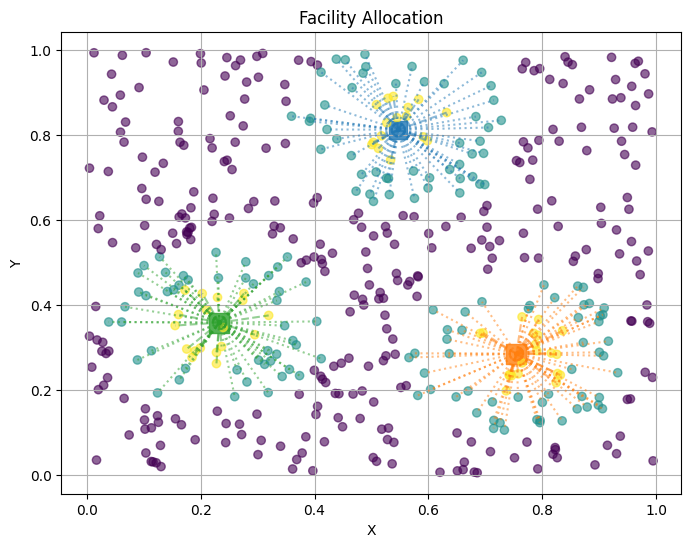

입지 위치별 만족하는 수요량 총합:
0    236.0
1    257.0
2    250.0
Name: Demand Sum, dtype: float64
결과적으로 만족되는 수요량 총합: 743.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 데이터 생성 및 알고리즘 계산 생략

satis_type = np.zeros(len(satis_demand))
for i in range(len(satis_demand)):
  if satis_demand[i] == demand_amounts[0][i] and satis_demand[i] != 0:
    satis_type[i] = 2
  elif satis_demand[i] == demand_amounts[1][i] and satis_demand[i] != 0:
    satis_type[i] = 1


# 결과 출력
facility_dataframe = pd.DataFrame(facility_points, columns=['X', 'Y'])
facility_dataframe['Demand Amount'] = np.bincount(facility_assignments, weights=satis_demand)
facility_dataframe['Satisfaction'] = np.zeros(num_facilities)

# 입지 지점별 만족하는 수요량 총합 계산
facility_demand_sums = np.bincount(facility_assignments, weights=satis_demand)
facility_dataframe['Demand Sum'] = facility_demand_sums

# 그래프 그리기
plt.figure(figsize=(8, 6))

# 마커 크기와 투명도 설정
marker_sizes = facility_demand_sums / np.max(facility_demand_sums) * 200  # 최대 크기의 5배를 초과하지 않도록 설정
marker_alpha = 0.8

# 입지 지점과 할당된 수요량 그리기
for i, facility_point in enumerate(facility_points):
    assigned_demand_points = demand_points[facility_assignments == i]
    if len(assigned_demand_points) > 0:
        # 입지 지점 그리기
        plt.scatter(facility_point[0], facility_point[1], color='C'+str(i), marker='s',
                    s=marker_sizes[i], alpha=marker_alpha, label='Facility '+str(i+1))

        # 수요 지점과 입지 지점 연결 그리기
        for demand_point in assigned_demand_points:
            distance = np.linalg.norm(facility_point - demand_point)  # 수요 지점과 입지 지점 사이의 거리 계산
            if distance <= distance_constraint_a:
                linestyle = '--'  # 거리가 0.1 이하일 때는 실선으로 설정
            elif distance > distance_constraint_b:
                continue  # 거리가 0.3을 넘어가면 직선을 그리지 않음
            else:
                linestyle = ':'  # 거리가 0.2 초과 0.4 이하일 때는 점선으로 설정
            plt.plot([facility_point[0], demand_point[0]], [facility_point[1], demand_point[1]], linestyle=linestyle, color='C'+str(i), alpha=0.5)

# 수요 지점 그리기
plt.scatter(demand_points[:, 0], demand_points[:, 1], c=satis_type, alpha=0.6, label='Demand Point')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Facility Allocation')
#plt.legend()
plt.grid(True)
plt.show()

# 입지 위치별 만족하는 수요량 총합 출력
print("입지 위치별 만족하는 수요량 총합:")
print(facility_dataframe['Demand Sum'])

# 결과적으로 만족되는 수요량 총합 출력
print("결과적으로 만족되는 수요량 총합:", facility_dataframe['Demand Sum'].sum())

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0])

In [ ]:
print('hello, world!')

hello, world!
